In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from alpaca.dataloader.builder import build_dataset

import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

import pdb
from tqdm import tqdm

from torchsummary import summary

%matplotlib inline

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torchType = torch.float32

### Data

```python 
DATASETS = {
    'boston_housing': BostonHousingData,
    'concrete': ConcreteData,
    'energy_efficiency': EnergyEfficiencyData,
    'kin8nm': Kin8nmData,
    'naval_propulsion': NavalPropulsionData,
    'ccpp': CCPPData,
    'protein_structure': ProteinStructureData,
    'red_wine': RedWineData,
    'yacht_hydrodynamics': YachtHydrodynamicsData,
    'year_prediction_msd': YearPredictionMSDData,
    'mnist': MnistData,
    'fashion_mnist': FashionMnistData,
    'cifar_10': Cifar10,
    'svhn': SVHN
}
```

In [3]:
num_epoches = 2001
print_info = 100

train_batch_size = 250
val_dataset = 10
val_batch_size = 10
test_batch_size = 10

In [4]:
class Dataset():
    def __init__(self, dataset_name='mnist'):
        self.dataset_name = dataset_name

        try:
            dataset = build_dataset(self.dataset_name, val_size=val_dataset)
        except TypeError:
            dataset = build_dataset(self.dataset_name, val_split=val_dataset)
        x_train, y_train = dataset.dataset('train')
        print(f'Train data shape {x_train.shape[0]}')
        self.train_ans = y_train
        self.in_features = x_train.shape[1:]
        x_val, y_val = dataset.dataset('val')
        
        if self.dataset_name in ['mnist', 'fashion_mnist']:
            x_train /= x_train.max()
            x_val /= x_val.max()
            x_shape = (-1, 1, 28, 28)
        else:
            x_shape = (-1, *x_train.shape[1:])
            
        train = TensorDataset(torch.tensor(x_train.reshape(x_shape), dtype=torch.float32, device=device), torch.tensor(y_train, dtype=torch.float32, device=device))
        validation = TensorDataset(torch.tensor(x_val.reshape(x_shape), dtype=torch.float32, device=device), torch.tensor(y_val, dtype=torch.float32, device=device))
        self.train_dataloader = DataLoader(train, batch_size=train_batch_size)
        self.val_dataloader = DataLoader(validation, batch_size=val_batch_size)
        
        if self.dataset_name=='mnist':
            test = datasets.MNIST(root=f'./data/{dataset_name}', download=True, train=False)
            data_test = test.test_data.type(torchType).to(device)
            labels_test = test.test_labels.type(torchType).to(device)

            self.test = data_test.data
            self.test_labels = labels_test.data

            test_data = []
            for i in range(self.test.shape[0]):
                test_data.append([self.test[i], self.test_labels[i]])
            self.test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=False)
    
    def next_train_batch(self):
        for train_batch in self.train_dataloader:
            batch = train_batch[0]
            labels = train_batch[1]
            if self.dataset_name in ['mnist', 'fashion_mnist']:
                batch = torch.distributions.Binomial(probs=batch).sample()
            yield batch, labels

    def next_val_batch(self):
        for val_batch in self.val_dataloader:
            batch = val_batch[0]
            labels = val_batch[1]
            yield batch, labels

    def next_test_batch(self):
        for test_batch in self.test_dataloader:
            batch = test_batch[0]
            labels = test_batch[1]
            if self.dataset_name in ['mnist', 'fashion_mnist']:
                batch = torch.distributions.Binomial(probs=batch).sample()
                batch = batch.view([-1, 1, 28, 28])
            yield batch, labels

In [5]:
dataset = Dataset(dataset_name='kin8nm')

Train data shape 8182


### NN definition

In [6]:
num_classes = np.unique(dataset.train_ans)
problem = 'classification' if len(num_classes) < 20 else 'regression'
if problem == 'regression':
    num_classes = 1
problem

'regression'

In [7]:
in_features = dataset.in_features[0]
in_features

8

In [8]:
last_features = 10

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        if problem == 'classification':
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2, padding=2)
            self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=2)
            self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2)
            self.linear1 = nn.Linear(in_features=1024, out_features=256)
            self.linear2 = nn.Linear(in_features=256, out_features=last_features)
        else:
            self.linear1 = nn.Linear(in_features=in_features, out_features=10*in_features)
            self.linear2 = nn.Linear(in_features=10*in_features, out_features=last_features)

    def forward(self, x):
        if problem == 'classification':
            h1 = torch.relu(self.conv1(x))
            h2 = torch.relu(self.conv2(h1))
            h3 = torch.relu(self.conv3(h2))
            h3_flat = h3.view(h3.shape[0], -1)
        else:
            h3_flat = x
        h4 = torch.relu(self.linear1(h3_flat))
        h5 = torch.relu(self.linear2(h4))
        return h5

In [10]:
model = Net().to(device)

In [11]:
if problem == 'classification':
    summary(model, input_size=(1, 28, 28))
else:
    summary(model, input_size=(1, in_features))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 80]             720
            Linear-2                [-1, 1, 10]             810
Total params: 1,530
Trainable params: 1,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


### Bayesian last layer definition

In [12]:
last_weight_mu = nn.Parameter(torch.randn((last_features, num_classes), device=device, dtype=torchType))
last_weight_logvar = nn.Parameter(torch.randn((last_features, num_classes), device=device, dtype=torchType))

last_bias_mu = nn.Parameter(torch.randn((1, num_classes), device=device, dtype=torchType))
last_bias_logvar = nn.Parameter(torch.randn((1, num_classes), device=device, dtype=torchType))

### Define optimizer

In [13]:
params = list(model.parameters()) + [last_weight_mu, last_weight_logvar] + [last_bias_mu, last_bias_logvar]
optimizer = torch.optim.Adam(params)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, np.linspace(start=10, stop=num_epoches, num=50), gamma=0.9)

### Training

In [14]:
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torchType),
                                       scale=torch.tensor(1., device=device, dtype=torchType),)

In [15]:
for ep in tqdm(range(num_epoches)):
    for x_train, y_train_labels in dataset.next_train_batch():
        emb = model(x_train)
        last_weight = last_weight_mu + std_normal.sample(last_weight_mu.shape) * torch.exp(0.5 * last_weight_logvar)
        last_bias = last_bias_mu + std_normal.sample(last_bias_mu.shape) * torch.exp(0.5 * last_bias_logvar)
        preds = emb @ last_weight + last_bias
        
        if problem == 'classification':
            log_likelihood = torch.distributions.Categorical(logits=preds).log_prob(y_train_labels).sum()
        else:
            log_likelihood = torch.distributions.Normal(loc=preds, scale=torch.tensor(1., device=device,
                                                                                      dtype=torchType)).log_prob(y_train_labels).sum()
    
        KL = (0.5 * (last_weight_logvar + torch.exp(last_weight_logvar) + last_weight_mu ** 2 - 1.)).mean() \
                        + (0.5 * (last_bias_logvar + torch.exp(last_bias_logvar) + last_bias_mu ** 2 - 1.)).mean()
        
        elbo = log_likelihood - KL
        (-elbo).backward()
        
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
        
    if ep % print_info == 0:
        print(f'ELBO value is {elbo.cpu().detach().numpy()} on epoch number {ep}')
        score_total = []
        with torch.no_grad():
            for x_val, y_val_labels in dataset.next_val_batch():
                emb = model(x_val)
                last_weight = last_weight_mu
                last_bias = last_bias_mu
                logits = emb @ last_weight + last_bias
                if problem == 'classification':
                    probs = torch.softmax(logits, dim=-1)
                    y_pred = torch.argmax(probs, dim=-1)
                    score = (y_pred==y_val_labels).to(torchType).cpu().mean().numpy()
                    score_total.append(score)
                else:
                    score = ((logits - y_val_labels)**2).mean().cpu().numpy()
                    score_total.append(score)
        if problem == 'classification':
            print(f"Mean validation accuracy at epoch number {ep} is {np.array(score_total).mean()}")
        else:
            print(f"Mean validation MSE at epoch number {ep} is {np.array(score_total).mean()}")

  0%|          | 2/2001 [00:00<04:04,  8.16it/s]

ELBO value is -177.44337463378906 on epoch number 0
Mean validation MSE at epoch number 0 is 0.07910880446434021


  5%|▌         | 102/2001 [00:10<03:34,  8.86it/s]

ELBO value is -170.5722198486328 on epoch number 100
Mean validation MSE at epoch number 100 is 0.03749695420265198


 10%|█         | 202/2001 [00:21<03:07,  9.59it/s]

ELBO value is -173.55624389648438 on epoch number 200
Mean validation MSE at epoch number 200 is 0.02899661660194397


 15%|█▌        | 302/2001 [00:32<02:56,  9.64it/s]

ELBO value is -162.8520965576172 on epoch number 300
Mean validation MSE at epoch number 300 is 0.004313061945140362


 20%|██        | 402/2001 [00:42<02:45,  9.64it/s]

ELBO value is -160.72100830078125 on epoch number 400
Mean validation MSE at epoch number 400 is 0.004701344761997461


 25%|██▌       | 502/2001 [00:53<02:35,  9.64it/s]

ELBO value is -157.72036743164062 on epoch number 500
Mean validation MSE at epoch number 500 is 0.00472988048568368


 30%|███       | 602/2001 [01:03<02:25,  9.64it/s]

ELBO value is -154.638671875 on epoch number 600
Mean validation MSE at epoch number 600 is 0.005516753997653723


 35%|███▌      | 702/2001 [01:14<02:14,  9.62it/s]

ELBO value is -151.55294799804688 on epoch number 700
Mean validation MSE at epoch number 700 is 0.006100443657487631


 40%|████      | 802/2001 [01:24<02:05,  9.58it/s]

ELBO value is -148.54502868652344 on epoch number 800
Mean validation MSE at epoch number 800 is 0.0058469693176448345


 45%|████▌     | 902/2001 [01:35<01:55,  9.51it/s]

ELBO value is -145.5498809814453 on epoch number 900
Mean validation MSE at epoch number 900 is 0.005393631756305695


 50%|█████     | 1002/2001 [01:45<01:46,  9.38it/s]

ELBO value is -142.5614776611328 on epoch number 1000
Mean validation MSE at epoch number 1000 is 0.004453153815120459


 55%|█████▌    | 1102/2001 [01:56<01:38,  9.13it/s]

ELBO value is -139.5754852294922 on epoch number 1100
Mean validation MSE at epoch number 1100 is 0.004472807515412569


 60%|██████    | 1202/2001 [02:06<01:22,  9.64it/s]

ELBO value is -136.59762573242188 on epoch number 1200
Mean validation MSE at epoch number 1200 is 0.004436977207660675


 65%|██████▌   | 1302/2001 [02:17<01:12,  9.63it/s]

ELBO value is -133.62002563476562 on epoch number 1300
Mean validation MSE at epoch number 1300 is 0.004694798029959202


 70%|███████   | 1402/2001 [02:27<01:02,  9.63it/s]

ELBO value is -130.64791870117188 on epoch number 1400
Mean validation MSE at epoch number 1400 is 0.0048730322159826756


 75%|███████▌  | 1502/2001 [02:38<00:51,  9.63it/s]

ELBO value is -127.67317962646484 on epoch number 1500
Mean validation MSE at epoch number 1500 is 0.005107625853270292


 80%|████████  | 1602/2001 [02:48<00:41,  9.62it/s]

ELBO value is -124.70042419433594 on epoch number 1600
Mean validation MSE at epoch number 1600 is 0.005158612038940191


 85%|████████▌ | 1702/2001 [02:59<00:31,  9.61it/s]

ELBO value is -121.730224609375 on epoch number 1700
Mean validation MSE at epoch number 1700 is 0.0051941643469035625


 90%|█████████ | 1802/2001 [03:09<00:20,  9.59it/s]

ELBO value is -118.76004791259766 on epoch number 1800
Mean validation MSE at epoch number 1800 is 0.00509707210585475


 95%|█████████▌| 1902/2001 [03:20<00:10,  9.53it/s]

ELBO value is -115.79113006591797 on epoch number 1900
Mean validation MSE at epoch number 1900 is 0.005043223965913057


100%|██████████| 2001/2001 [03:30<00:00,  9.50it/s]

ELBO value is -112.81855773925781 on epoch number 2000
Mean validation MSE at epoch number 2000 is 0.004980697762221098


# Inference for classification

### Inference

TypeError: Invalid shape (13,) for image data

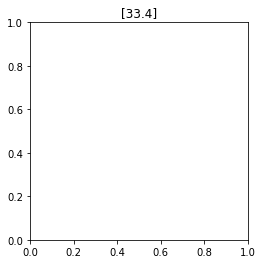

In [17]:
val_image_id = 10


for batch in dataset.next_val_batch():
    test_image = batch[0][val_image_id].squeeze()
    test_label = batch[1][val_image_id]

plt.title(f"{test_label.cpu().numpy()}")
plt.imshow(test_image.cpu().numpy());

In [ ]:
n_samples = 100

results = []
with torch.no_grad():
    for _ in range(n_samples):
        emb = model(test_image[None, None, ...])
        last_weight = last_weight_mu + std_normal.sample(last_weight_mu.shape) * torch.exp(0.5 * last_weight_logvar)
        last_bias = last_bias_mu + std_normal.sample(last_bias_mu.shape) * torch.exp(0.5 * last_bias_logvar)
        
        logits = emb @ last_weight + last_bias
        probs = torch.softmax(logits, dim=-1)
        y_pred = torch.argmax(probs, dim=-1)
        results.append(y_pred.cpu().item())
        

labels, counts = np.unique(results, return_counts=True)
plt.bar(labels, counts, align='center')
plt.xticks(ticks=np.arange(10))
plt.xlim((-1, 10));

### Find digits with non-trivial distribution

In [ ]:
n_samples = 100

for val_batch in dataset.next_val_batch():
    val_images = val_batch[0]
    val_labels = val_batch[1]
    for i in range(val_images.shape[0]):
        test_image = val_images[i].squeeze()
        test_label = val_labels[i].squeeze()
        plt.close()
        results = []
        with torch.no_grad():
            for _ in range(n_samples):
                emb = model(test_image[None, None, ...])
                last_weight = last_weight_mu + std_normal.sample(last_weight_mu.shape) * torch.exp(0.5 * last_weight_logvar)
                last_bias = last_bias_mu + std_normal.sample(last_bias_mu.shape) * torch.exp(0.5 * last_bias_logvar)

                logits = emb @ last_weight + last_bias
                probs = torch.softmax(logits, dim=-1)
                y_pred = torch.argmax(probs, dim=-1)
                results.append(y_pred.cpu().item())
        if np.unique(results).shape[0] > 1: # or np.unique(results)[0] != test_label:
            print('-' * 100)
            plt.title(f"{test_label.cpu().numpy()}")
            plt.imshow(test_image.cpu().numpy());
            plt.show()

            labels, counts = np.unique(results, return_counts=True)
            plt.bar(labels, counts, align='center')
            plt.xticks(ticks=np.arange(10))
            plt.xlim((-1, 10));
            plt.show();

# Inference for Regression

In [20]:
val_image_id = 2


for batch in dataset.next_val_batch():
    test_image = batch[0][val_image_id].squeeze()
    test_label = batch[1][val_image_id]

print(test_label)

tensor([21.2000], device='cuda:0')


In [21]:
n_samples = 100

results = []
with torch.no_grad():
    for _ in range(n_samples):
        if problem == 'classification':
            emb = model(test_image[None, None, ...])
        else:
            emb = model(test_image[None,  ...])
        last_weight = last_weight_mu + std_normal.sample(last_weight_mu.shape) * torch.exp(0.5 * last_weight_logvar)
        last_bias = last_bias_mu + std_normal.sample(last_bias_mu.shape) * torch.exp(0.5 * last_bias_logvar)
        
        logits = emb @ last_weight + last_bias
        results.append(logits.cpu().item())
        
print('Marginalized answer ', np.mean(results))
print('True answer', test_label)

Marginalized answer  22.375574111938477
True answer tensor([21.2000], device='cuda:0')
